# Four Ways to Calculate Modified Duration (And I Am Sure There Are More)
You can compute modified duration via the closed‑form Macaulay‑duration formula in its exact or pproximative incarnation, direct cash‑flow differentiation, or finite‑difference (bump‑and‑reprice). Below you get explanations, detailed proofs and copy‑paste‑ready Python cells that create bonds on a yield curve and calculate duration all four ways.

We start by loading the required libraries for our calculations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## 1. Svensson spot curve and discount factors

We assume a continuous‐compounded spot rate curve \( s(t) \) parameterized by the
Svensson model:

$$
s(t) = \beta_0
     + \beta_1 \frac{1 - e^{-t/\tau_1}}{t/\tau_1}
     + \beta_2 \left(
         \frac{1 - e^{-t/\tau_1}}{t/\tau_1}
         - e^{-t/\tau_1}
       \right)
     + \beta_3 \left(
         \frac{1 - e^{-t/\tau_2}}{t/\tau_2}
         - e^{-t/\tau_2}
       \right).
$$

Given this spot rate, the discount factor for maturity $ t $ is

$$
DF(t) = e^{-s(t)\,t}.
$$

We then pick Svensson parameter values to generate a spot rate curve.


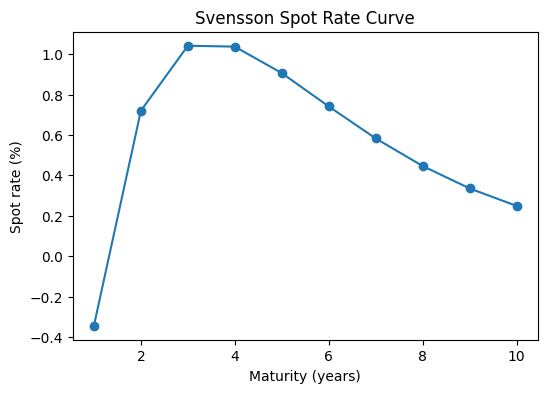

,Tenor,SpotRate,DiscountFactor
0,1,-0.003445,1.003451
1,2,0.007198,0.985708
2,3,0.010416,0.969235
3,4,0.010371,0.959365
4,5,0.009060,0.955711
5,6,0.007411,0.956510
6,7,0.005826,0.960038
7,8,0.004460,0.964949
8,9,0.003350,0.970296
9,10,0.002486,0.975447


In [2]:
# Svensson parameters (example values)
beta0 = 0.01   # long-term level (1%)
beta1 = -0.04  # drives very low short rates (down from beta0)
beta2 =  0.09  # big positive hump around tau1
beta3 = -0.05  # negative hump further out
tau1  = 1.5    # first hump around 1.5y
tau2  = 6.0    # second hump around 6y

def svensson_spot_rate(t):
    """Continuous-compounded spot rate s(t) for maturity t (in years)."""
    t = np.asarray(t, dtype=float)
    t = np.where(t == 0, 1e-6, t)  # avoid division by zero
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-t / tau1)) / (t / tau1)
    term3 = beta2 * ((1 - np.exp(-t / tau1)) / (t / tau1) - np.exp(-t / tau1))
    term4 = beta3 * ((1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2))
    return term1 + term2 + term3 + term4

def svensson_discount_factor(t):
    """Discount factor DF(t) from Svensson spot curve."""
    s = svensson_spot_rate(t)
    return np.exp(-s * t)

# Example tenors 1..10y
tenors = np.arange(1, 11)
curve_df = pd.DataFrame({
    "Tenor": tenors,
    "SpotRate": svensson_spot_rate(tenors),
    "DiscountFactor": svensson_discount_factor(tenors)
})

plt.figure(figsize=(6, 4))
plt.plot(tenors, curve_df["SpotRate"] * 100, marker="o")
plt.xlabel("Maturity (years)")
plt.ylabel("Spot rate (%)")
plt.title("Svensson Spot Rate Curve")
plt.show()

curve_df

## 2. Pricing simple fixed coupon bonds on the curve

We now define a helper function that prices **plain, annual coupon bonds**
by discounting each cash flow with the Svensson‑based discount factors.

For a bond with:

- face value $ F $,
- annual coupon rate $ c $,
- maturity $ T $ (in years),
- annual coupon frequency $ f = 1 $,

the cash flows are

- $ CF_t = F \cdot c $ at each coupon date $ t = 1, \dots, T-1 $,
- $ CF_T = F \cdot c + F $ at maturity.

The price from the Svensson curve is

$$
P = \sum_{t=1}^{T} CF_t \, DF(t).
$$


In [3]:
def bond_price_from_curve(maturity, coupon_rate, face=100.0, freq=1):
    """
    Price a fixed-rate bond on the Svensson curve, using DF(t) from svensson_discount_factor.
    - maturity in years
    - coupon_rate as decimal (e.g. 0.03)
    - freq: coupons per year (here we keep freq=1 for simplicity)
    """
    n = int(maturity * freq)
    times = np.arange(1, n + 1) / freq

    coupon = face * coupon_rate / freq
    cf = np.full(n, coupon)
    cf[-1] += face   # principal at maturity

    dfs = svensson_discount_factor(times)
    return float(np.sum(cf * dfs))

# Example bonds
bonds = pd.DataFrame({
    "Maturity": [1, 2, 5, 7, 10],
    "CouponRate": [0.01, 0.02, 0.035, 0.045, 0.05],
})
bonds["Price"] = [
    bond_price_from_curve(m, c) for m, c in zip(bonds["Maturity"], bonds["CouponRate"])
]
bonds


,Maturity,CouponRate,Price
0,1,0.010,101.348567
1,2,0.020,102.549104
2,5,0.035,112.628202
3,7,0.045,126.558866
4,10,0.050,146.048232


## 3. Method I: Modified duration from Macaulay duration

For a bond priced off a **constant yield** $ y $ (effective annual, with annual coupons),
we can write the price as

$$
P(y) = \sum_{t=1}^{T} \frac{CF_t}{(1 + y)^t}.
$$

The **Macaulay duration** is the present‑value‑weighted average time of the cash flows:

$$
D_\text{Mac}(y) =
\sum_{t=1}^{T} \left( \frac{CF_t / (1+y)^t}{P(y)} \right) t.
$$

The **modified duration** can be calculated as

$$
D_\text{mod}(y) = \frac{D_\text{Mac}(y)}{1 + y}.
$$

Economically, modified duration gives the approximate **percentage price change**
for a small change in yield:

$$
\frac{\Delta P}{P} \approx - D_\text{mod} \, \Delta y.
$$

***Proof I: Relationship between Macaulay and modified duration***

We start from the definition of the bond price as a function of the (effective, annual) yield
$y$) with annual coupon payments:

$$
P(y) = \sum_{t=1}^{T} \frac{CF_t}{(1+y)^t}.
$$

The **Macaulay duration** at yield $y$ is defined as the present‑value‑weighted average
time of the cash flows:

$$
D_{\text{Mac}}(y)
= \sum_{t=1}^{T} \left( \frac{CF_t/(1+y)^t}{P(y)} \right) t.
$$

The **modified duration** at yield $y$ is defined via the derivative of price with respect
to yield:

$$
D_{\text{mod}}(y)
= -\frac{1}{P(y)} \frac{dP(y)}{dy}.
$$

We now show that

$$
D_{\text{mod}}(y) = \frac{D_{\text{Mac}}(y)}{1+y}.
$$

First compute the derivative of the price with respect to \(y\). Each term in the sum

$$
P(y) = \sum_{t=1}^{T} CF_t (1+y)^{-t}
$$

has derivative

$$
\frac{d}{dy} \left[ CF_t (1+y)^{-t} \right]
= CF_t \cdot \left( -t (1+y)^{-t-1} \right)
= -t \frac{CF_t}{(1+y)^{t+1}}.
$$

Summing over all cash flows,

$$
\frac{dP(y)}{dy}
= \sum_{t=1}^{T} \left( -t \frac{CF_t}{(1+y)^{t+1}} \right)
= -\frac{1}{1+y} \sum_{t=1}^{T} t \frac{CF_t}{(1+y)^t}.
$$

Substitute this into the definition of modified duration:

$$
D_{\text{mod}}(y)
= -\frac{1}{P(y)} \frac{dP(y)}{dy}
= -\frac{1}{P(y)} \left(
  -\frac{1}{1+y} \sum_{t=1}^{T} t \frac{CF_t}{(1+y)^t}
\right).
$$

The two minus signs cancel, so

$$
D_{\text{mod}}(y)
= \frac{1}{1+y} \cdot \frac{1}{P(y)} \sum_{t=1}^{T} t \frac{CF_t}{(1+y)^t}.
$$

Rewriting the factor $1/P(y)$ inside the sum,

$$
D_{\text{mod}}(y)
= \frac{1}{1+y} \sum_{t=1}^{T}
  \left( \frac{CF_t/(1+y)^t}{P(y)} \right) t.
$$

But the term in parentheses is exactly the weight that appears in the definition of
Macaulay duration, so

$$
D_{\text{Mac}}(y)
= \sum_{t=1}^{T}
  \left( \frac{CF_t/(1+y)^t}{P(y)} \right) t,
$$

which implies

$$
D_{\text{mod}}(y)
= \frac{1}{1+y} D_{\text{Mac}}(y)
= \frac{D_{\text{Mac}}(y)}{1+y}.
$$

Thus, for annual compounding, the modified duration is the Macaulay duration divided by
$1 + y$.

***end of proof I*


***Proof II: Relationship between modified duration, price and yield***

We start from the definition of modified duration as the (negative) first derivative of
log price with respect to yield:

$$
D_{\text{mod}}(y) = -\frac{1}{P(y)} \frac{dP(y)}{dy}.
$$

We now derive the approximate price change formula

$$
\frac{\Delta P}{P} \approx - D_{\text{mod}} \, \Delta y.
$$

We consider a small change in yield from $y$ to $y + \Delta y$. For small changes we can
approximate the price change using a **first‑order Taylor expansion** around $y$:

$$
P(y + \Delta y) \approx P(y) + \frac{dP(y)}{dy} \, \Delta y.
$$

Subtracting $P(y)$ from both sides gives an approximation for the absolute change in price:

$$
\Delta P \approx \frac{dP(y)}{dy} \, \Delta y.
$$

Next we divide both sides by the initial price $P(y)$ to get the **relative** price change:

$$
\frac{\Delta P}{P(y)} \approx \frac{1}{P(y)} \frac{dP(y)}{dy} \, \Delta y.
$$

By definition of modified duration we have

$$
D_{\text{mod}}(y) = -\frac{1}{P(y)} \frac{dP(y)}{dy},
$$

so

$$
\frac{1}{P(y)} \frac{dP(y)}{dy} = - D_{\text{mod}}(y).
$$

Substituting this into the expression for the relative price change yields

$$
\frac{\Delta P}{P(y)} \approx - D_{\text{mod}}(y) \, \Delta y.
$$

This is the standard linear approximation: for a small change in yield $\Delta y$, the bond
price changes by approximately $-D_{\text{mod}} \, \Delta y$ in percentage terms.

***end of proof II***

To compute these for each bond, we first solve for the flat yield $ y $ that reproduces
its Svensson‑based price, then apply the formulas above.


In [4]:
def bond_price_from_yield(maturity, coupon_rate, y, face=100.0, freq=1):
    n = int(maturity * freq)
    times = np.arange(1, n + 1) / freq

    coupon = face * coupon_rate / freq
    cf = np.full(n, coupon)
    cf[-1] += face

    disc = (1 + y / freq) ** (freq * times)
    return float(np.sum(cf / disc))


def solve_yield(price, maturity, coupon_rate, face=100.0, freq=1, guess=0.03):
    """
    Simple Newton method to solve y that matches a given price.
    """
    y = guess
    for _ in range(20):
        n = int(maturity * freq)
        times = np.arange(1, n + 1) / freq

        coupon = face * coupon_rate / freq
        cf = np.full(n, coupon)
        cf[-1] += face

        disc = (1 + y / freq) ** (freq * times)
        pv = cf / disc
        p = float(np.sum(pv))

        # derivative dP/dy
        factor = -freq * times / (1 + y / freq)
        dPdy = float(np.sum(pv * factor))

        y -= (p - price) / dPdy

    return y


def macaulay_duration(price, maturity, coupon_rate, y, face=100.0, freq=1):
    n = int(maturity * freq)
    times = np.arange(1, n + 1) / freq

    coupon = face * coupon_rate / freq
    cf = np.full(n, coupon)
    cf[-1] += face

    disc = (1 + y / freq) ** (freq * times)
    pv = cf / disc

    weights = pv / price
    return float(np.sum(weights * times))


def modified_duration(price, maturity, coupon_rate, y, face=100.0, freq=1):
    mac = macaulay_duration(price, maturity, coupon_rate, y, face, freq)
    return mac / (1 + y / freq)


In [5]:
results = []

for _, row in bonds.iterrows():
    m = row["Maturity"]
    c = row["CouponRate"]
    p = row["Price"]

    y = solve_yield(p, m, c)  # flat yield matching the Svensson-based price
    mac = macaulay_duration(p, m, c, y)
    mod = modified_duration(p, m, c, y)

    results.append({
        "Maturity": m,
        "CouponRate": c,
        "Price": p,
        "Yield": y,
        "MacDur": mac,
        "ModDur": mod,
    })

dur_df = pd.DataFrame(results)
dur_df


,Maturity,CouponRate,Price,Yield,MacDur,ModDur
0,1.0,0.010,101.348567,-0.003439,1.000000,1.003451
1,2.0,0.020,102.549104,0.007118,1.980635,1.966636
2,5.0,0.035,112.628202,0.009053,4.694782,4.652659
3,7.0,0.045,126.558866,0.006124,6.265339,6.227206
4,10.0,0.050,146.048232,0.003150,8.477041,8.450421


## 4. Method II: Modified duration from a symmetric finite‑difference approximation on the yield curve

Instead of assuming each bond has its own flat yield $ y $, we can link duration
directly to the **underlying curve**.

We define a **parallel shift** of the Svensson spot curve by $ \Delta y $ (in decimal)
and re‑price the bond using the shifted discount factors:

- $ P_0 $: original price from the base curve,
- $ P_\text{up} $: price when all spot rates are shifted up by $ +\Delta y $,
- $ P_\text{down} $: price when all spot rates are shifted down by $ -\Delta y $.

A symmetric finite‑difference approximation to modified duration is

$$
D_\text{mod} \approx
- \frac{P_\text{up} - P_\text{down}}{2 P_0 \Delta y}.
$$

***Proof III:  Symmetric finite‑difference approximation to modified duration***

The modified duration is defined in continuous form as a derivative of the bond price
with respect to yield $y$:

$$
D_{\text{mod}}(y)
= -\frac{1}{P(y)} \frac{dP(y)}{dy}.
$$

In practice we do not usually compute $ \frac{dP}{dy} $ analytically but approximate it
numerically by **finite differences**. The idea is to reprice the bond at slightly different
yields and use those prices to approximate the slope.

A **one‑sided** (forward) finite‑difference approximation would use

$$
\frac{dP(y)}{dy}
\approx \frac{P(y + \Delta y) - P(y)}{\Delta y},
$$

but this is only first‑order accurate and introduces a directional bias (it only looks
“to the right” of $y$).

A **symmetric** (or central) finite‑difference approximation uses one bump up and one
bump down:

$$
\frac{dP(y)}{dy}
\approx \frac{P(y + \Delta y) - P(y - \Delta y)}{2\,\Delta y}.
$$

This uses information on both sides of $y$ and is typically more accurate for the
same bump size $ \Delta y $.

Substituting this into the definition of modified duration, we obtain the symmetric
finite‑difference approximation:

$$
D_{\text{mod}}(y)
= -\frac{1}{P(y)} \frac{dP(y)}{dy}
\approx
-\frac{1}{P_0}\,
\frac{P_{+} - P_{-}}{2\,\Delta y},
$$

where

- $P_0 = P(y)$ is the original price at yield $y$,
- $P_{+} = P(y + \Delta y)$ is the price after an upward yield bump,
- $P_{-} = P(y - \Delta y)$ is the price after a downward yield bump.

Rewriting this in a more compact way:

$$
D_{\text{mod}}(y)
\approx
-\,\frac{P_{+} - P_{-}}{2\,P_0\,\Delta y}.
$$

In words:

- Bump the yield up and down by a small amount $ \Delta y $ (e.g. 1 bp),
- Compute the corresponding prices $P_{+}$ and $P_{-}$,
- Plug them into the formula above.

The result is a numerical estimate of modified duration that does not require an
explicit analytic derivative and works even when the pricing comes from a complex
model or a full yield curve rather than a simple closed‑form expression.

***end of proof III***

Here we interpret the shift in terms of **continuous spot rate** in the Svensson formula.


In [6]:
def svensson_discount_factor_shifted(t, shift_bp):
    """
    Discount factor from Svensson curve shifted in parallel by shift_bp (e.g. +1 bp).
    Shift is applied to the continuous spot rate.
    """
    shift = shift_bp / 10000.0  # bp to decimal
    s = svensson_spot_rate(t) + shift
    return np.exp(-s * t)


def bond_price_from_curve_shifted(maturity, coupon_rate, shift_bp, face=100.0, freq=1):
    n = int(maturity * freq)
    times = np.arange(1, n + 1) / freq

    coupon = face * coupon_rate / freq
    cf = np.full(n, coupon)
    cf[-1] += face

    dfs = svensson_discount_factor_shifted(times, shift_bp)
    return float(np.sum(cf * dfs))


def modified_duration_curve_fd(maturity, coupon_rate, shift_bp=1.0, face=100.0, freq=1):
    """
    Curve-based modified duration via parallel bp bump on the Svensson curve.
    shift_bp is the bump size in basis points.
    """
    p0 = bond_price_from_curve(maturity, coupon_rate, face, freq)
    p_up = bond_price_from_curve_shifted(maturity, coupon_rate, +shift_bp, face, freq)
    p_dn = bond_price_from_curve_shifted(maturity, coupon_rate, -shift_bp, face, freq)

    dy = shift_bp / 10000.0
    return - (p_up - p_dn) / (2 * p0 * dy)


In [7]:
dur_df["ModDur_curveFD"] = [
    modified_duration_curve_fd(m, c)
    for m, c in zip(dur_df["Maturity"], dur_df["CouponRate"])
]

dur_df


,Maturity,CouponRate,Price,Yield,MacDur,ModDur,ModDur_curveFD
0,1.0,0.010,101.348567,-0.003439,1.000000,1.003451,1.000000
1,2.0,0.020,102.549104,0.007118,1.980635,1.966636,1.980430
2,5.0,0.035,112.628202,0.009053,4.694782,4.652659,4.693321
3,7.0,0.045,126.558866,0.006124,6.265339,6.227206,6.268523
4,10.0,0.050,146.048232,0.003150,8.477041,8.450421,8.499043


## 5. Method III: Modified duration from the analytic derivative

For a plain fixed‑rate bond with annual coupons and yield $ y $, the price is

$$
P(y) = \sum_{t=1}^{T} \frac{CF_t}{(1 + y)^t}.
$$

The derivative of the price with respect to yield is

$$
\frac{dP(y)}{dy}
= \sum_{t=1}^{T} \frac{d}{dy} \left( CF_t (1+y)^{-t} \right)
= \sum_{t=1}^{T} \left( -t \frac{CF_t}{(1+y)^{t+1}} \right).
$$

The modified duration is defined as

$$
D_{\text{mod}}(y)
= -\frac{1}{P(y)} \frac{dP(y)}{dy}.
$$

Substituting the expression for $\frac{dP(y)}{dy}$ gives

$$
D_{\text{mod}}(y)
= -\frac{1}{P(y)}
  \left(
    \sum_{t=1}^{T} -t \frac{CF_t}{(1+y)^{t+1}}
  \right)
= \frac{1}{P(y)(1+y)}
  \sum_{t=1}^{T} t \frac{CF_t}{(1+y)^t}.
$$

We can rewrite this as

$$
D_{\text{mod}}(y)
= \frac{1}{1+y}
  \sum_{t=1}^{T}
  \left(
    \frac{CF_t / (1+y)^t}{P(y)}
  \right) t,
$$

which shows again that modified duration is Macaulay duration divided by $1+y$, but it
also gives us a direct way to compute $D_{\text{mod}}$ from the cash‑flow formula
without explicitly forming $D_{\text{Mac}}$.


In [8]:
def modified_duration_analytic(price, maturity, coupon_rate, y, face=100.0, freq=1):
    """
    Modified duration via analytic derivative dP/dy.

    P(y) = sum CF_t / (1 + y/f)^(f * t)
    dP/dy = sum CF_t * d/dy[(1 + y/f)^(-f t)]
          = sum CF_t * ( -f t * (1 + y/f)^(-f t - 1) )
    We implement this using the already discounted PV_t = CF_t / (1 + y/f)^(f t).
    """
    n = int(maturity * freq)
    times = np.arange(1, n + 1) / freq

    coupon = face * coupon_rate / freq
    cf = np.full(n, coupon)
    cf[-1] += face

    disc = (1 + y / freq) ** (freq * times)
    pv = cf / disc  # present values at yield y

    # price at yield y
    p = price  # we pass in price so we don't recompute unnecessarily

    # derivative dP/dy using PV_t:
    # PV_t = CF_t / (1 + y/f)^(f t)
    # dPV_t/dy = PV_t * ( -f * t / (1 + y/f) )
    factor = -freq * times / (1 + y / freq)
    dPdy = float(np.sum(pv * factor))

    # modified duration
    return -dPdy / p


In [9]:
rows = []
for _, row in bonds.iterrows():
    m = row["Maturity"]
    c = row["CouponRate"]
    p = row["Price"]

    # Yield from Svensson-based price
    y = solve_yield(p, m, c)

    # Method 1: from Macaulay
    mac = macaulay_duration(p, m, c, y)
    mod_mac = modified_duration(p, m, c, y)

    # Method 2: analytic derivative
    mod_analytic = modified_duration_analytic(p, m, c, y)

    # Method 3: curve bump-and-reprice
    mod_curve_fd = modified_duration_curve_fd(m, c)

    rows.append({
        "Maturity": m,
        "CouponRate": c,
        "Price": p,
        "Yield": y,
        "MacDur": mac,
        "ModDur_Mac": mod_mac,
        "ModDur_Analytic": mod_analytic,
        "ModDur_CurveFD": mod_curve_fd,
    })

dur_df = pd.DataFrame(rows)

dur_df


,Maturity,CouponRate,Price,Yield,MacDur,ModDur_Mac,ModDur_Analytic,ModDur_CurveFD
0,1.0,0.010,101.348567,-0.003439,1.000000,1.003451,1.003451,1.000000
1,2.0,0.020,102.549104,0.007118,1.980635,1.966636,1.966636,1.980430
2,5.0,0.035,112.628202,0.009053,4.694782,4.652659,4.652659,4.693321
3,7.0,0.045,126.558866,0.006124,6.265339,6.227206,6.227206,6.268523
4,10.0,0.050,146.048232,0.003150,8.477041,8.450421,8.450421,8.499043


## 6. Method IV: Modified duration from a closed‑form approximation for Macaulay

For a fixed‑rate bond with:

- maturity \(T\) (in years),
- annual coupon rate \(c\) (as decimal, e.g. 0.05),
- yield‑to‑maturity \(y\) (effective annual),
- face value \(F = 100\),

the bond price is

$$
P(y) = \sum_{t=1}^{T} \frac{F c}{(1+y)^t} + \frac{F}{(1+y)^T}.
$$

If we write out the Macaulay duration definition and simplify the geometric sums,
we obtain a **closed‑form expression** (for annual coupons, no amortization):

$$
D_\text{Mac}(y)
\approx
\frac{1 + y}{y}
-
\frac{1 + y + T \left(c - y\right)}
     {c \left((1+y)^T - 1\right) + y}.
$$

In code we often express $c$ as a percentage, so $c = \text{coupon}/100$.

Once we have this Macaulay duration, the **modified duration** is

$$
D_\text{mod}(y) = \frac{D_\text{Mac}(y)}{1 + y}.
$$

***Proof IV: deriving a close-form approximation for Macaulay duration***

Consider a fixed-rate bond as described above.

The price as a function of yield is

$$
P(y) = \sum_{t=1}^{T} \frac{F c}{(1+y)^t} + \frac{F}{(1+y)^T}.
$$

The Macaulay duration is

$$
D_\text{Mac}(y)
= \sum_{t=1}^{T}
  \left(
    \frac{CF_t / (1+y)^t}{P(y)}
  \right) t
= \frac{1}{P(y)} \sum_{t=1}^{T} t \frac{CF_t}{(1+y)^t},
$$

where $CF_t = F c$ for $t=1,\dots,T-1$ and $CF_T = F c + F$.

Define the numerator

$$
N(y) = \sum_{t=1}^{T} t \frac{CF_t}{(1+y)^t}.
$$

We split it into coupon and principal parts:

$$
N(y) =
\sum_{t=1}^{T} t \frac{F c}{(1+y)^t}
+
T \frac{F}{(1+y)^T}.
$$

Factor out constants:

$$
N(y) =
F c \sum_{t=1}^{T} t (1+y)^{-t}
+
T F (1+y)^{-T}.
$$

So the key object is the sum

$$
S_1 = \sum_{t=1}^{T} t (1+y)^{-t}.
$$


Start with the simpler geometric sum

$$
S_0 = \sum_{t=1}^{T} (1+y)^{-t}
= \frac{1 - (1+y)^{-T}}{y}.
$$

We want a closed form for

$$
S_1 = \sum_{t=1}^{T} t (1+y)^{-t}.
$$

A standard trick is to recognize that $S_1$ is (up to a sign) the derivative of
$S_0$ with respect to $(1+y)$, or to use known formulas for the sum of an
arithmetic–geometric series. The result (which can be verified by algebra or
induction) is

$$
S_1
=
\frac{1 + y}{y^2}
-
\frac{(1+y) + T y}{y^2 (1+y)^T}.
$$

You can check this quickly by plugging small values of $T$ and $y$ and
comparing with the direct sum.

First the *price*:

$$
P(y) = F c S_0 + \frac{F}{(1+y)^T}
= F c \frac{1 - (1+y)^{-T}}{y} + F (1+y)^{-T}.
$$

Factor out $F$ (we will set $F=100$ at the end):

$$
P(y)
= F \left[
  c \frac{1 - (1+y)^{-T}}{y} + (1+y)^{-T}
\right].
$$

Now the *Macaulay numerator*:

$$
N(y) = F c S_1 + T F (1+y)^{-T}.
$$

Substitute the closed form for $S_1$:

$$
N(y)
= F c \left[
    \frac{1 + y}{y^2}
    - \frac{(1+y) + T y}{y^2 (1+y)^T}
  \right]
  + T F (1+y)^{-T}.
$$

At this point everything is algebra. The Macaulay duration is

$$
D_\text{Mac}(y) = \frac{N(y)}{P(y)}.
$$


After canceling $F$ and doing some algebraic simplification (common
denominators, grouping terms in $(1+y)^{-T}$, etc.), the ratio
$D_\text{Mac}(y) = N(y)/P(y)\$ can be rearranged into the compact form

$$
D_\text{Mac}(y)
=
\frac{1 + y}{y}
-
\frac{1 + y + T(c - y)}
     {c\bigl((1+y)^T - 1\bigr) + y}.
$$

This is the approximation expression stated above. The formula for modified duration remains the same.

***end of proof IV***

In [10]:
def macaulay_duration_closed_form(T, coupon_rate, y):
    """
    Closed-form Macaulay duration for a level-coupon bond (annual coupons).
    T           : maturity in years (integer)
    coupon_rate : annual coupon rate as decimal (e.g. 0.05)
    y           : yield-to-maturity as decimal
    """
    c = coupon_rate
    num1 = (1 + y) / y
    num2 = (1 + y + T * (c - y))
    den2 = c * ((1 + y)**T - 1) + y
    return num1 - num2 / den2


def modified_duration_closed_form(T, coupon_rate, y):
    mac_cf = macaulay_duration_closed_form(T, coupon_rate, y)
    return mac_cf / (1 + y)


# Add closed-form approximate modified duration as a new column
dur_df["ModDur_Mac_Approx"] = [
    modified_duration_closed_form(int(m), c, y)
    for m, c, y in zip(dur_df["Maturity"], dur_df["CouponRate"], dur_df["Yield"])
]

dur_df


,Maturity,CouponRate,Price,Yield,MacDur,ModDur_Mac,ModDur_Analytic,ModDur_CurveFD,ModDur_Mac_Approx
0,1.0,0.010,101.348567,-0.003439,1.000000,1.003451,1.003451,1.000000,1.003451
1,2.0,0.020,102.549104,0.007118,1.980635,1.966636,1.966636,1.980430,1.966636
2,5.0,0.035,112.628202,0.009053,4.694782,4.652659,4.652659,4.693321,4.652659
3,7.0,0.045,126.558866,0.006124,6.265339,6.227206,6.227206,6.268523,6.227206
4,10.0,0.050,146.048232,0.003150,8.477041,8.450421,8.450421,8.499043,8.450421


## 7. Interpretations

We now have four ways to compute modified duration:

1. **Macaulay-based modified duration (YTM view)**  
2. **Analytic-derivative modified duration (YTM view, same math as 1)**  
3. **Curve-based finite-difference modified duration (Svensson view)**
4. **Approximative Macaulay-based modified duration (YTM view)**

They are closely related, but they answer slightly different questions about how the
bond price reacts to interest-rate changes.

### What the Macaulay / YTM-based modified duration measures

For a plain fixed-rate bond, we can always define a single **yield-to-maturity** $y$
such that the standard flat-yield pricing formula reproduces the bond’s price:

$$
P(y) = \sum_{t=1}^{T} \frac{CF_t}{(1+y)^t}.
$$

Here $y$ is a *summary statistic*: it is the one constant discount rate that, if the
entire world had a flat yield curve at level $y$, would give **this bond** the same
price as the true (possibly non-flat) term structure.

From this $P(y)$, we define:

- **Macaulay duration** (PV-weighted average time of the cash flows)
  $$
  D_{\text{Mac}}(y)
  = \sum_{t=1}^{T} \left( \frac{CF_t / (1+y)^t}{P(y)} \right) t,
  $$
- **Modified duration** as a function of Macaulay duration
  $$
  D_{\text{mod}}(y)
  = \frac{D_{\text{Mac}}(y)}{1+y}
  = -\frac{1}{P(y)} \frac{dP(y)}{dy}.
  $$

Economically, this \(D_{\text{mod}}(y)\) answers:

> “If the **flat YTM** of this bond changes by a small amount \(\Delta y\), what is the
>  approximate percentage change in its price?”

$$
\frac{\Delta P}{P} \approx -D_{\text{mod}}(y)\,\Delta y.
$$

So the YTM-based modified duration is a **scalar** sensitivity to a **single yield**,
not explicitly to the whole term structure.

Method IV uses the closed‑form formula above instead of explicitly summing
discounted cash flows.

- **Input**: maturity $T$, coupon rate $c$, and yield‑to‑maturity $y$.
- **Step 1**: compute the approximate Macaulay duration
  $D_\text{Mac}(y)$ using the closed‑form expression.
- **Step 2**: obtain modified duration as
  $D_\text{mod}(y) = D_\text{Mac}(y)/(1+y)$.

Conceptually this is still a **YTM‑based** duration (like Methods I and II), but:

- It is **computationally cheap** and convenient for teaching, spreadsheets,
  and quick calculations.
- It makes the dependence on $(T, c, y)$ explicit in a single formula.

### What the curve-based finite-difference duration measures

In our notebook we also defined a duration that comes directly from the **Svensson
spot curve**, without ever converting to a flat YTM. The pricing uses continuous
spot rates $s(t)$ and discount factors

$$
DF(t) = e^{-s(t)\,t},
$$

with \(s(t)\) coming from the Svensson formula. The bond price is

$$
P_0 = \sum_{t=1}^{T} CF_t \, DF(t).
$$

To compute a **curve-based modified duration**, we:

1. **Shift the entire Svensson spot curve in parallel** by a small amount
   \(\Delta y\) (e.g. \(+1\) bp or \(-1\) bp), i.e.
   $$
   s_\pm(t) = s(t) \pm \Delta y,
   \quad
   DF_\pm(t) = e^{-s_\pm(t)\,t}.
   $$

2. Reprice the bond on these shifted curves:
   $$
   P_{+} = \sum_{t=1}^{T} CF_t \, DF_{+}(t),
   \qquad
   P_{-} = \sum_{t=1}^{T} CF_t \, DF_{-}(t).
   $$

3. Use the **symmetric finite-difference** approximation
   $$
   D_{\text{mod, curve}}
   \approx -\frac{P_{+} - P_{-}}{2 P_0 \,\Delta y}.
   $$

This duration is not tied to a flat YTM. It measures the price sensitivity to a
**parallel shift of the entire (non-flat) Svensson term structure**.

So the curve-based modified duration answers: “If **all spot rates** on the Svensson curve move up or down by \(\Delta y\), what is the approximate percentage change in the bond’s price?”

This is often closer to how risk is managed in practice (shift the curve) than
changing a single YTM.

### Why the numbers can be close - or not

In the earlier, relatively smooth Svensson examples, the three measures

- $D_{\text{mod, Mac}}$) (from Macaulay + YTM),
- $D_{\text{mod, analytic}}$ (same YTM view via direct derivative),
- $D_{\text{mod, curveFD}}$ (from Svensson curve bump-and-reprice)

were numerically very close. That was because:

1. The bonds were **simple, non-callable fixed-rate** instruments.  
2. The **Svensson curve was fairly smooth** over the relevant maturities.  
3. For each bond, the implied YTM \(y\) was a very good “average” of the spot/forward
   rates that actually discount its cash flows.  
4. The parallel shift \(\Delta y\) used in the finite difference was **small**, so the
   price–yield relation was nearly linear over that range and the FD approximation was
   very accurate.

After changing the Svensson parameters to create a **much more curved / humped**
term structure, the situation changes:

- The discount factors at different maturities react **unevenly** to a parallel shift,
  because the underlying spots are at very different levels and slopes.  
- The single YTM \(y\) is now a much **coarser summary** of the curve’s shape; two yield
  curves with very different curvature can give the same YTM for a given bond.  
- As a result, “shift the flat YTM by \(\Delta y\)” and “shift the entire Svensson curve
  by \(\Delta y\)” no longer produce almost identical price changes, especially for
  bonds whose cash flows sit in the most curved parts of the curve.

Therefore, with a more extreme Svensson curve you should see:

- \$D_{\text{mod, Mac}}$ and $D_{\text{mod, analytic}}$ still matching each other
  (they are just two ways of computing the same YTM-based derivative).  
- \$D_{\text{mod, curveFD}}$ diverging more clearly from those YTM-based values,
  especially for mid-maturity bonds where the curve’s hump or steep slope matters most.

### When each measure is most useful

- Use **Macaulay exact or approximative / analytic modified duration** when:
  - You want a quick, closed-form approximation based on YTM.
  - The curve is not too distorted and the bond is vanilla and non-callable.

- Use **curve-based finite-difference duration** when:
  - You think in terms of **term-structure shifts** (e.g. “+10 bp parallel move”).
  - The curve has strong slope/curvature and you care about how the *whole curve*
    impacts price.
  - The instrument is priced by a more complex model or has embedded options, so
    YTM-based formulas are not trustworthy.

Having all four calculation methods in one notebook is very instructive: you can see directly when the
flat-YTM view is a good approximation to the curve view, and when it starts to break
down. When changing the Svensson curve parameters, you can see how the methodologies perform in different curve scenarios.
